In [73]:
# !pip install torch
# !pip install torchvision

In [74]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [75]:
# FC VAE Architecture
class FCVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(FCVAE, self).__init__()
        # Encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        # Decoder
        self.fc2 = nn.Linear(latent_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h1 = torch.relu(self.fc1(x))
        return self.fc_mu(h1), self.fc_logvar(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h2 = torch.relu(self.fc2(z))
        return torch.sigmoid(self.fc3(h2)).view(-1, 3, 32, 32)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [76]:
# Conv VAE Architecture
class ConvVAE(nn.Module):
    def __init__(self, latent_dim):
        super(ConvVAE, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        self.conv_mu = nn.Linear(256 * 2 * 2, latent_dim)
        self.conv_logvar = nn.Linear(256 * 2 * 2, latent_dim)
        self.z = nn.Linear(latent_dim, 256 * 2 * 2)
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        mu = self.conv_mu(x)
        logvar = self.conv_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = self.z(z)
        x = x.view(-1, 256, 2, 2)
        x = self.decoder(x)
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [77]:
# Loss function
def loss_function_cvae(recon_x, x, mu, logvar, beta=1):
    MSE = nn.functional.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + beta * KLD, MSE, KLD

def loss_function_fcvae(recon_x, x, mu, logvar, beta=1):    
    BCE = nn.functional.binary_cross_entropy(recon_x.view(-1, 3072), x.view(-1, 3072), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + beta * KLD, BCE, KLD

In [78]:
# Training the VAE
def train(model, train_loader, optimizer, epoch, num_epochs, model_name, device):
    model.train()
    train_loss_total = 0
    recon_loss_total = 0
    kld_loss_total = 0
    with tqdm(train_loader, unit='batch', desc=f'Epoch {epoch}', colour='green') as tepoch:
        for batch_idx, (data, _) in enumerate(tepoch):
            if model_name == 'cvae':
                data = data.view(data.size(0), 3, 32, 32).to(device)
            elif model_name == 'fcvae':
                data = data.view(data.size(0), -1).to(device)   
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            if model_name == 'cvae':
                loss_function = loss_function_cvae
            elif model_name == 'fcvae':
                loss_function = loss_function_fcvae
            total_loss, recon_loss, kld_loss = loss_function(recon_batch, data, mu, logvar)
            total_loss.backward()
            train_loss_total += total_loss.item()
            recon_loss_total += recon_loss.item()
            kld_loss_total += kld_loss.item()
            optimizer.step()
            tepoch.set_postfix(
                train_loss=train_loss_total / len(train_loader.dataset),
                recon_loss=recon_loss_total / len(train_loader.dataset),
                kld_loss=kld_loss_total / len(train_loader.dataset)
            )
    print(f'Epoch {epoch}/{num_epochs} train loss: {train_loss_total / len(train_loader.dataset)} mse loss: {recon_loss_total / len(train_loader.dataset)} kld loss: {kld_loss_total / len(train_loader.dataset)}')

In [79]:
num_epochs = 5
lr = 2e-3

In [80]:
# Train the CVAE
transform_cvae = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

train_dataset_cvae = datasets.CIFAR10('./data/cvae', train=True, download=True, transform=transform_cvae)
train_loader_cvae = torch.utils.data.DataLoader(train_dataset_cvae, batch_size=128, shuffle=True)

cvae = ConvVAE(latent_dim=128).to(device)
optimizer_cvae = optim.Adam(cvae.parameters(), lr=lr)

for epoch in range(1, num_epochs + 1):
    train(cvae, train_loader_cvae, optimizer_cvae, epoch, num_epochs, 'cvae', device)

Files already downloaded and verified


Epoch 1: 100%|██████████| 391/391 [02:51<00:00,  2.28batch/s, kld_loss=18.5, recon_loss=627, train_loss=645]  


Epoch 1/5 train loss: 645.26392640625 mse loss: 626.729909921875 kld loss: 18.53401673339844


Epoch 2: 100%|██████████| 391/391 [01:25<00:00,  4.56batch/s, kld_loss=20.2, recon_loss=564, train_loss=584]  


Epoch 2/5 train loss: 583.78097375 mse loss: 563.614063671875 kld loss: 20.16691063964844


Epoch 3: 100%|██████████| 391/391 [01:09<00:00,  5.61batch/s, kld_loss=23.5, recon_loss=539, train_loss=563]  


Epoch 3/5 train loss: 562.51873078125 mse loss: 539.022569296875 kld loss: 23.49616123046875


Epoch 4: 100%|██████████| 391/391 [01:10<00:00,  5.56batch/s, kld_loss=25.3, recon_loss=525, train_loss=550]  


Epoch 4/5 train loss: 550.454253125 mse loss: 525.168038046875 kld loss: 25.28621508300781


Epoch 5: 100%|██████████| 391/391 [01:10<00:00,  5.52batch/s, kld_loss=26.4, recon_loss=517, train_loss=543]  

Epoch 5/5 train loss: 543.464607890625 mse loss: 517.043442578125 kld loss: 26.421164658203125


In [81]:
# Train the FCVAE
transform_fcvae = transforms.Compose([
    transforms.ToTensor()
])

train_dataset_fcvae = datasets.CIFAR10('./data/fcvae', train=True, download=True, transform=transform_fcvae)
train_loader_fcvae = torch.utils.data.DataLoader(train_dataset_fcvae, batch_size=128, shuffle=True)

fcvae = FCVAE(input_dim=3072, hidden_dim=400, latent_dim=128)
optimizer_fcvae = optim.Adam(fcvae.parameters(), lr=lr)

for epoch in range(1, num_epochs + 1):
    train(fcvae, train_loader_fcvae, optimizer_fcvae, epoch, num_epochs, 'fcvae', device)

Files already downloaded and verified


Epoch 1: 100%|██████████| 391/391 [00:20<00:00, 18.80batch/s, kld_loss=17.9, recon_loss=1.97e+3, train_loss=1.99e+3]


Epoch 1/5 train loss: 1992.743896875 mse loss: 1974.8821525 kld loss: 17.86174534713745


Epoch 2: 100%|██████████| 391/391 [00:21<00:00, 17.91batch/s, kld_loss=16.6, recon_loss=1.92e+3, train_loss=1.94e+3]


Epoch 2/5 train loss: 1939.44372375 mse loss: 1922.892621875 kld loss: 16.551101943359374


Epoch 3: 100%|██████████| 391/391 [00:26<00:00, 14.81batch/s, kld_loss=13.8, recon_loss=1.92e+3, train_loss=1.93e+3]


Epoch 3/5 train loss: 1930.01629125 mse loss: 1916.2264209375 kld loss: 13.789874725341797


Epoch 4: 100%|██████████| 391/391 [00:26<00:00, 14.77batch/s, kld_loss=12.7, recon_loss=1.91e+3, train_loss=1.93e+3]


Epoch 4/5 train loss: 1926.063100625 mse loss: 1913.3289425 kld loss: 12.73415790649414


Epoch 5: 100%|██████████| 391/391 [00:24<00:00, 15.74batch/s, kld_loss=12.3, recon_loss=1.91e+3, train_loss=1.92e+3]

Epoch 5/5 train loss: 1924.257716875 mse loss: 1911.986981875 kld loss: 12.270733780517578


In [97]:
import matplotlib.pyplot as plt

# Function to generate and display new images
def generate_images(model, num_images, latent_dim):
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Turn off gradients for generation
        # Sample random points from the latent space (standard normal distribution)
        z = torch.randn(num_images, latent_dim)
        # Decode these points to generate images
        generated_images = []
        for i in tqdm(range(num_images), desc='Generating images', unit='image', colour='blue'):
            generated_image = model.decode(z[i:i+1]).cpu()
            generated_images.append(generated_image)
    # Convert the generated images to a single tensor
    generated_images = torch.cat(generated_images, dim=0)

    # Plot the generated images
    fig, axs = plt.subplots(1, num_images, figsize=(num_images, 1.5))
    for i in range(num_images):
        axs[i].imshow(generated_images[i].numpy().transpose(1, 2, 0))
        axs[i].axis('off')
    plt.show()

Images from FC VAE


Generating images: 100%|██████████| 5/5 [00:00<00:00, 410.35image/s]


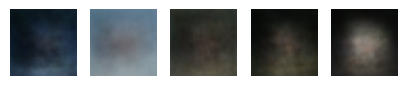

Images from Conv VAE


Generating images: 100%|██████████| 5/5 [00:00<00:00, 155.87image/s]


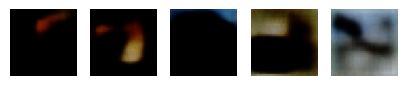

In [98]:
# Assuming you have already trained the model (vae) and it has a latent dimension of 128
print('Images from FC VAE')
generate_images(fcvae, num_images=5, latent_dim=128)

print('Images from Conv VAE')
generate_images(cvae, num_images=5, latent_dim=128)